# James Challenge Solution 
## by Sara Pereira

The data from Lending Club 2016 is read from .csv files and consolidated into a pandas dataframe. 

The proposed questions are answered using basics methods of pandas. 
When exploring data it is seen how is the volume distribution of loan amounts, and how the grade of loans affects the target variable.

This data set has a very high dimensionality so it has to be reduced. Variables that are mostly missing data are removed. It is then analysed the correlation between numerical variables, and some more are eliminated. Dates are turned into time periods and categorical variables are encoded. 

The data set is split into training set and test set, and it is ensured that every scaler or model is only fitted to the training set, and then applied to the test set.

After standardising the data, some models are compared for the prediction of the loan status. The choice of models was done so it would contain classification models of different types (implementing different techniques).
The results are evaluated in terms of recall, precision, f1 score mathews correlation coefficient and AUC with a ROC. 
All models deliver extraordinary performance, resulting from careful feature engineering.

Some comments and analysis are made along the script.


# Import Statements

In [1]:
import os
import numpy as np
import pandas as pd
import math

# time
import datetime
from monthdelta import *

# visualization
import seaborn as sns
from matplotlib import pyplot as plt

#models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# these models take too long to process
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
%matplotlib inline 

# Read and Merge Files

In [2]:
files = ['LoanStats/LoanStats_2016Q1.csv', 'LoanStats/LoanStats_2016Q2.csv', 'LoanStats/LoanStats_2016Q3.csv', 'LoanStats/LoanStats_2016Q4.csv']
frames = ['Q1', 'Q2', 'Q3', 'Q4']
ddf = {}

for frame, file in zip(frames, files):
    ddf[frame] = pd.read_csv(file, skiprows=1, low_memory=False)
    print('Successfuly read {}. Data corresponds to the following issuing months:'.format(file))
    print(ddf[frame]['issue_d'].value_counts())

df = pd.concat(ddf)


Successfuly read LoanStats/LoanStats_2016Q1.csv. Data corresponds to the following issuing months:
Mar-2016    61992
Feb-2016    39529
Jan-2016    32366
Name: issue_d, dtype: int64
Successfuly read LoanStats/LoanStats_2016Q2.csv. Data corresponds to the following issuing months:
Apr-2016    36432
Jun-2016    33019
May-2016    28403
Name: issue_d, dtype: int64
Successfuly read LoanStats/LoanStats_2016Q3.csv. Data corresponds to the following issuing months:
Aug-2016    36280
Jul-2016    34696
Sep-2016    28144
Name: issue_d, dtype: int64
Successfuly read LoanStats/LoanStats_2016Q4.csv. Data corresponds to the following issuing months:
Dec-2016    36183
Nov-2016    34591
Oct-2016    32772
Name: issue_d, dtype: int64


In [3]:
df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
Q1 0  NaN        NaN    12000.0      12000.0          12000.0   60 months   
   1  NaN        NaN     8000.0       8000.0           8000.0   36 months   
   2  NaN        NaN     8200.0       8200.0           8200.0   36 months   
   3  NaN        NaN    14000.0      14000.0          14000.0   36 months   
   4  NaN        NaN    15000.0      15000.0          15000.0   36 months   

     int_rate  installment grade sub_grade       ...        \
Q1 0    6.97%       237.45     A        A3       ...         
   1   11.99%       265.68     C        C1       ...         
   2   11.47%       270.29     B        B5       ...         
   3   10.75%       456.69     B        B4       ...         
   4    9.16%       478.12     B        B2       ...         

     hardship_payoff_balance_amount hardship_last_payment_amount  \
Q1 0                            NaN                          NaN   
   1                            NaN                          NaN   
   2                            NaN                          NaN   
   3                            NaN                          NaN   
   4                            NaN                          NaN   

     disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
Q1 0                Cash                     N                       NaN   
   1                Cash                     N                       NaN   
   2                Cash                     N                       NaN   
   3                Cash                     N                       NaN   
   4                Cash                     N                       NaN   

     settlement_status settlement_date settlement_amount  \
Q1 0               NaN             NaN               NaN   
   1               NaN             NaN               NaN   
   2               NaN             NaN               NaN   
   3               NaN             NaN               NaN   
   4               NaN             NaN               NaN   

      settlement_percentage settlement_term  
Q1 0                    NaN             NaN  
   1                    NaN             NaN  
   2                    NaN             NaN  
   3                    NaN             NaN  
   4                    NaN             NaN  

[5 rows x 145 columns]

# Questions 

### a. How many loans are *there*?

In [4]:
df.shape[0]

434415

### b. How many columns does the dataset have?

In [5]:
df.shape[1]

145

### c. How many columns only contain missing data?

Columns only containing missing data won't be of help so we might as well just eliminate them 

In [6]:
df.dropna(axis=1, how='all', inplace=True) 
print('Removed column(s) = 145 - {} = {}'.format(df.shape[1], (145-df.shape[1]))) # 145 is the original number of columns 

Removed column(s) = 145 - 132 = 13


### d. How many loans are still current? 

'Current' is one of the possible loan status with 225496 instances

In [7]:
df['loan_status'].value_counts()

Current               225496
Fully Paid            145318
Charged Off            50819
Late (31-120 days)      6728
In Grace Period         4518
Late (16-30 days)       1517
Default                   11
Name: loan_status, dtype: int64

# Subset Exploration

The exploration takes into account that the goal is to predict the probability of a loan being charged off. 

From now on the variable 'loan_status' is considered the target variable

In [8]:
# subset creation 

df = df[((df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off'))] # the other categories won't be needed 
                                                                                      # so I'll just rewrite the df variable
df['loan_status'].value_counts() # Charged Off status acounts for ~25% of the dataset

Fully Paid     145318
Charged Off     50819
Name: loan_status, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 196137 entries, (Q1, 2) to (Q4, 103544)
Columns: 132 entries, id to settlement_term
dtypes: float64(94), object(38)
memory usage: 199.5+ MB


In [10]:
# Remove columns with only missing data that may have surged after subsetting
df.dropna(axis=1, how='all', inplace=True) 
print('Removed column(s) = 132 - {} = {}'.format(df.shape[1], (132-df.shape[1])))

Removed column(s) = 132 - 130 = 2


### Distribution of Loan amount 


50% of the loan amounts id under 12000.0


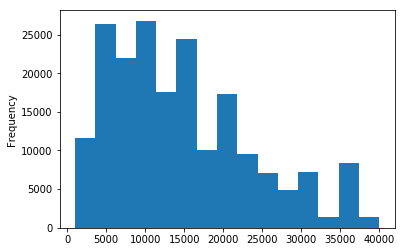

In [11]:
df.loan_amnt.plot(kind="hist", bins=15)
print('50% of the loan amounts id under {}'.format(df.loan_amnt.median()))

### Loan grade volumes (filtered by loan status)
The results suggest the loan grade may play an important role on the loan being charged off. As one can see there is a big difference between both distributions.

##### Charged Off Loans

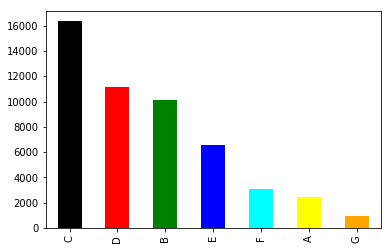

In [12]:
df[df['loan_status'] == 'Charged Off'].grade.value_counts().plot(kind='bar', color = 
                                                                 ['black', 'red', 'green', 'blue', 'cyan', 'yellow', 'orange'])

##### Fully paid loans

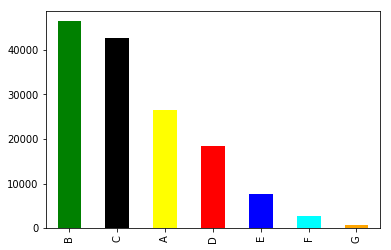

In [13]:
df[df['loan_status'] == 'Fully Paid'].grade.value_counts().plot(kind='bar', color = 
                                                                ['green', 'black', 'yellow', 'red', 'blue', 'cyan', 'orange'])

## Variable exploration

##### Variables that are mostly NaN 
The variables with only missing values were already removed. However, given the high dimensionality of the problem it is wise to remove the ones where more than half values are NaN

In [14]:
#determine NaN percentage
check_null = df.isnull().sum().sort_values(ascending=False)/len(df)

#print all with more than 50% NaNs
print(check_null[check_null > 0.50])

desc                                          0.999924
orig_projected_additional_accrued_interest    0.996992
deferral_term                                 0.993601
hardship_amount                               0.993601
hardship_start_date                           0.993601
hardship_end_date                             0.993601
payment_plan_start_date                       0.993601
hardship_length                               0.993601
hardship_dpd                                  0.993601
hardship_loan_status                          0.993601
hardship_payoff_balance_amount                0.993601
hardship_status                               0.993601
hardship_last_payment_amount                  0.993601
hardship_type                                 0.993601
hardship_reason                               0.993601
annual_inc_joint                              0.982543
dti_joint                                     0.982543
verification_status_joint                     0.982543
settlement

In [15]:
# Remove more than 50% NaN variables
df.drop(check_null[check_null > 0.5].index, axis=1, inplace=True)
df.dropna(axis=0, thresh=30,inplace=True)
print('Removed column(s) = 130 - {} = {}'.format(df.shape[1], (130-df.shape[1])))

Removed column(s) = 130 - 102 = 28


##### Variable Correlation

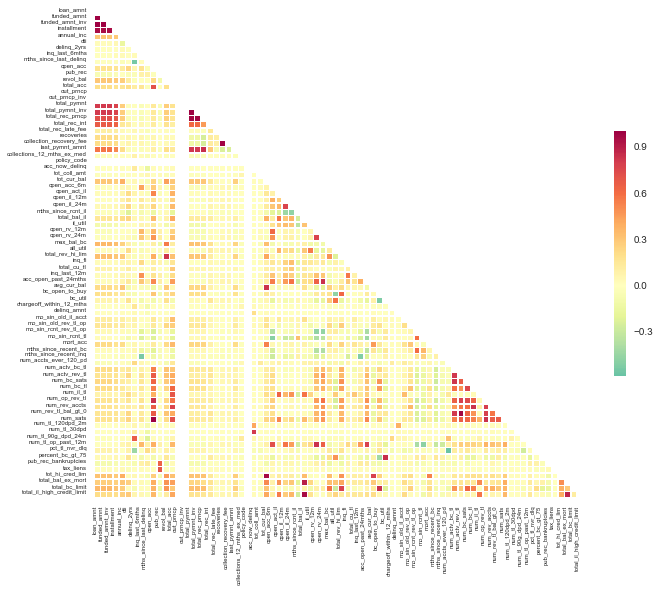

In [16]:
# Select numerical variables
num = df.select_dtypes(include=np.number)
names = num.columns.values

# Compute the correlation matrix
corr = num.corr()

# Visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Spectral_r'
# sns.diverging_palette(100, 275 , as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#ax.tick_params(labelsize=8)
plt.yticks(range(num.shape[1]), names,rotation=0, size=6)
#plt.xticks(rotation=90)
plt.xticks(range(num.shape[1]), names, rotation=90, size=6)
plt.show()

 Correlation is not causation. However, since the number of numerical variables is so high we can still check the pairs where the absolute correlation value is higher than 85% and discard some high correlated variables on the basis that they would offer approximately the same information, being redundant. 

In [17]:
dataCorr = corr.mask(np.tril(np.ones(corr.shape)).astype(np.bool))
dataCorr = dataCorr[abs(dataCorr) >= 0.85].stack().reset_index()
print(dataCorr[:50])

              level_0                     level_1         0
0           loan_amnt                 funded_amnt  1.000000
1           loan_amnt             funded_amnt_inv  0.999992
2           loan_amnt                 installment  0.956304
3         funded_amnt             funded_amnt_inv  0.999992
4         funded_amnt                 installment  0.956304
5     funded_amnt_inv                 installment  0.956220
6            open_acc                    num_sats  0.998653
7         total_pymnt             total_pymnt_inv  0.999994
8         total_pymnt             total_rec_prncp  0.979293
9     total_pymnt_inv             total_rec_prncp  0.979288
10         recoveries     collection_recovery_fee  0.987253
11        tot_cur_bal             tot_hi_cred_lim  0.957448
12       total_bal_il           total_bal_ex_mort  0.895452
13       total_bal_il  total_il_high_credit_limit  0.960351
14    num_actv_rev_tl         num_rev_tl_bal_gt_0  0.975562
15  total_bal_ex_mort  total_il_high_cre

- The correlation between 'loan_amnt', 'funded_amnt', and 'funded_amnt_inv' is avery high, so let's keep only the 'funded_amnt' which represents the amount actually funded
- let's also remove  'loan_amnt', 'installment', 'num_sats', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_il_high_credit_limit' and 'num_rev_tl_bal_gt_0'. 

In [18]:
df.drop(['loan_amnt', 'installment', 'num_sats', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 
         'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'num_rev_tl_bal_gt_0'], axis = 1, inplace = True)

print('Removed column(s) = 102 - {} = {}'.format(df.shape[1], (102-df.shape[1])))

Removed column(s) = 102 - 92 = 10


By now the variables were reduced <b>from 145 to 92</b> by removing high NaN percentage variables, and highly correlated. 
Let's check the remaining variables for categorical data types and for more reduction possibilities. 

In [19]:
for col in df.select_dtypes(include=['object']).columns:
    print ("Column '{}' has {} unique instances ({}) {} \n".format(
        col, len(df[col].unique()), df[col].unique()[:50], 
        '.' if len(df[col].unique()) <= 50 else ('. Only showing first 50.')))

Column 'term' has 2 unique instances ([' 36 months' ' 60 months']) . 

Column 'int_rate' has 138 unique instances ([' 11.47%' '  9.16%' ' 14.46%' ' 10.75%' ' 13.67%' ' 18.25%' ' 15.31%'
 ' 11.99%' ' 19.53%' ' 16.29%' '  5.32%' ' 12.99%' ' 24.11%' '  7.39%'
 ' 17.27%' '  9.75%' '  8.39%' ' 22.45%' ' 21.18%' '  7.89%' ' 19.99%'
 '  6.49%' ' 20.75%' ' 18.99%' '  6.97%' ' 28.34%' ' 21.97%' ' 24.99%'
 ' 26.57%' ' 28.99%' ' 28.14%' '  6.00%' ' 23.13%' ' 28.67%' ' 25.88%'
 ' 27.34%' ' 15.29%' ' 10.78%' '  9.17%' ' 12.88%' ' 13.44%' '  7.91%'
 ' 11.48%' ' 13.99%' '  6.99%' '  8.49%' ' 24.24%' ' 26.99%' ' 16.59%'
 ' 18.49%']) . Only showing first 50. 

Column 'grade' has 7 unique instances (['B' 'C' 'D' 'A' 'F' 'E' 'G']) . 

Column 'sub_grade' has 35 unique instances (['B5' 'B2' 'C4' 'B4' 'C3' 'D3' 'C5' 'C1' 'D5' 'D1' 'A1' 'C2' 'F2' 'A4'
 'D2' 'B3' 'B1' 'E5' 'E3' 'A5' 'E1' 'A2' 'E2' 'D4' 'A3' 'G3' 'E4' 'F3'
 'F5' 'G5' 'G2' 'F1' 'G4' 'F4' 'G1']) . 

Column 'emp_title' has 64407 unique instances 

- 'term'
        -> TURN TO INT TYPE
- 'int_rate' 
        -> TURN TO FLOAT TYPE
- 'grade' 
        -> CATEGORICAL
- 'subgrade'
        -> CATEGORICAL
- 'emp_title' free text, high cardinality.
        -> REMOVE
- 'emp_length' 
        -> TURN TO INT TYPE
- 'home_ownership'
        -> CATEGORICAL
- 'verification_status' 
        -> CATEGORICAL
- 'issue_d' 
        -> ELAPSED DATE       
- 'loan_status' 
        -> REMOVE !!! TARGET VARIABLE !!! 
- 'pymnt_plan' constant column 
        -> REMOVE
- 'purpose' 
        -> CATEGORICAL 
- 'title' same info as purpose
        -> REMOVE
- 'zip_code' categorical high cardinality 
        -> REMOVE
- 'addr_state' categorical high cardinality
        -> REMOVE
- 'earliest_cr_line' 
        -> ELAPSED DATE
- 'revol_util' 
        -> TURN TO FLOAT TYPE
- 'initial_list_status' 
        -> CATEGORICAL
- 'last_pymnt_d' not considered relevant
        -> REMOVE 
- 'last_credit_pull_d' not considered relevant
        -> REMOVE
- 'application_type' 
        -> CATEGORICAL 
- 'hardship_flag' constant  
        -> REMOVE
- 'disbursement_method' 
        -> CATEGORICAL
- 'debt_settlement_flag' 
        -> CATEGORICAL

#### Variables 1 - 50

In [20]:
df.iloc[:5,:50]

funded_amnt  funded_amnt_inv        term int_rate grade sub_grade  \
Q1 2        8200.0           8200.0   36 months   11.47%     B        B5   
   4       15000.0          15000.0   36 months    9.16%     B        B2   
   8       16000.0          16000.0   60 months   14.46%     C        C4   
   13       8400.0           8400.0   36 months   10.75%     B        B4   
   17      10000.0          10000.0   36 months   11.47%     B        B5   

              emp_title emp_length home_ownership  annual_inc      ...       \
Q1 2   Registered Nurse  10+ years           RENT     70000.0      ...        
   4         mainteance    2 years       MORTGAGE     55000.0      ...        
   8       Fire fighter  10+ years       MORTGAGE     69000.0      ...        
   13               NaN        NaN            OWN     24000.0      ...        
   17       parts sales  10+ years       MORTGAGE     55000.0      ...        

      application_type acc_now_delinq tot_coll_amt tot_cur_bal open_acc_6m  \
Q1 2        Individual            0.0        149.0     37329.0         1.0   
   4        Individual            0.0        403.0     96061.0         0.0   
   8        Individual            0.0          0.0    205141.0         0.0   
   13       Individual            0.0          0.0     23541.0         1.0   
   17       Individual            0.0          0.0     46363.0         3.0   

      open_act_il open_il_12m open_il_24m  mths_since_rcnt_il  total_bal_il  
Q1 2          1.0         0.0         1.0                15.0       30992.0  
   4          1.0         0.0         0.0                28.0       12499.0  
   8          2.0         0.0         1.0                24.0       63369.0  
   13         0.0         0.0         0.0                73.0           0.0  
   17         1.0         1.0         2.0                 6.0       13286.0  

[5 rows x 50 columns]

In [21]:
# turn 'term' to int
df.term = pd.Series(df.term).str.replace('months', '').astype(int)

# turn 'int_rate' to float 

df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)
df.int_rate.values # array([11.47,  9.16, 14.46, ..., 14.49, 12.79, 14.49])

# turn 'emp_length' to int using regex (NaN -> 0)

df.emp_length.fillna(value=0,inplace=True)
df.emp_length.replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emp_length = df.emp_length.astype(int)
df.emp_length.dtype # dtype('int32')

# turn 'issue_d', 'earliest_cr_line' to months elapsed since (...) -> see Date Variables

# turn 'revol_util' to float 

df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

# turn 'application_type' to binary
df.application_type = pd.Series(df.application_type).str.replace('Individual', '1')
df.application_type = pd.Series(df.application_type).str.replace('Joint App', '0').astype(int)

# turn 'initial_list_status' to binary
df.initial_list_status = pd.Series(df.initial_list_status).str.replace('w', '1')
df.initial_list_status = pd.Series(df.initial_list_status).str.replace('f', '0').astype(int)

# turn 'disbursement_method' to binary 
df.disbursement_method = pd.Series(df.disbursement_method).str.replace('Cash', '1')
df.disbursement_method = pd.Series(df.disbursement_method).str.replace('DirectPay', '0').astype(int)

# turn 'debt_settlement_flag' to binary 
df.debt_settlement_flag = pd.Series(df.debt_settlement_flag).str.replace('Y', '1')
df.debt_settlement_flag = pd.Series(df.debt_settlement_flag).str.replace('N', '0').astype(int)

# remove 'out_prncp' and 'out_prncp_inv' null variables

# remove 'policy_code' constant column



#### Variables 50 - 100

In [22]:
df.iloc[:5,50:]

il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  \
Q1 2       NaN          1.0          3.0      4536.0      42.0   
   4      58.0          0.0          2.0      1287.0      58.0   
   8      79.0          0.0          1.0      2187.0      82.0   
   13      NaN          1.0          3.0      7085.0      49.0   
   17     95.0          2.0          3.0      2150.0      88.0   

       total_rev_hi_lim  inq_fi  total_cu_tl  inq_last_12m  \
Q1 2            15200.0     1.0          0.0           1.0   
   4             9600.0     0.0          0.0           0.0   
   8             7300.0     0.0          6.0           1.0   
   13           48100.0     0.0          0.0           1.0   
   17            6000.0     0.0          0.0           2.0   

       acc_open_past_24mths          ...           num_tl_90g_dpd_24m  \
Q1 2                    4.0          ...                          0.0   
   4                    2.0          ...                          0.0   
   8                    2.0          ...                          0.0   
   13                   3.0          ...                          0.0   
   17                   5.0          ...                          0.0   

       num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  \
Q1 2                  1.0            94.4              33.3   
   4                  0.0           100.0             100.0   
   8                  0.0            90.9             100.0   
   13                 1.0            92.3               0.0   
   17                 3.0            68.7              75.0   

       pub_rec_bankruptcies  tax_liens  total_bc_limit  hardship_flag  \
Q1 2                    0.0        5.0          9300.0              N   
   4                    0.0        0.0          1400.0              N   
   8                    0.0        0.0          2300.0              N   
   13                   0.0        0.0         33800.0              N   
   17                   0.0        0.0          6000.0              N   

       disbursement_method  debt_settlement_flag  
Q1 2                     1                     0  
   4                     1                     0  
   8                     1                     0  
   13                    1                     0  
   17                    1                     0  

[5 rows x 42 columns]

In [23]:
# turn 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 
                            #'debt_settlement_flag_date', 'settlement_date' to periods -> see Date Variables

# 'hardship_flag'-> Remove (constant)

## Pre -Processing

##### High Cardinality variables

In [24]:
# Remove high cardinality variables 

df.drop(['emp_title', 'pymnt_plan', 'title', 'zip_code', 'addr_state', 'out_prncp', 'out_prncp_inv', 
        'policy_code', 'hardship_flag', 'last_pymnt_d', 'last_credit_pull_d'], axis = 1, inplace = True)

print('Removed column(s) = 92 - {} = {}'.format(df.shape[1], (91-df.shape[1])))


Removed column(s) = 92 - 81 = 10


##### Time Variables


In [25]:
dates = ['issue_d' , 'earliest_cr_line']
dfdates = df[dates].copy()
dfdates[dates] = '1-' + df[dates].astype(str) 
dfdates.head()
dfdates.shape

(196137, 2)

In [26]:
dfdates.head()

issue_d earliest_cr_line
Q1 2   1-Mar-2016       1-Jun-2006
   4   1-Mar-2016       1-Dec-2003
   8   1-Mar-2016       1-May-2005
   13  1-Mar-2016       1-Oct-1989
   17  1-Mar-2016       1-Nov-1983

In [27]:
# Turn columns to datetime objects
dfdates.issue_d = pd.to_datetime(dfdates.issue_d)
dfdates.earliest_cr_line = pd.to_datetime(dfdates.earliest_cr_line)

# Today's datetime
today = datetime.date.today()

# Turn datetimes into elapsed months since the dates to today using monthmod.py
dfdates.issue_d = dfdates.issue_d.apply(lambda x: (
    monthmod(x, pd.Timestamp(today))[0].months))
dfdates.earliest_cr_line = dfdates.earliest_cr_line.apply(lambda x: (
    monthmod(x, pd.Timestamp(today))[0].months))

In [28]:
df[dates] = dfdates.astype(int)
df[dates].head()

issue_d  earliest_cr_line
Q1 2        28               145
   4        28               175
   8        28               158
   13       28               345
   17       28               416

##### Categorical Variables

In [29]:
# Categorical variables from previous analysis
# 
cat = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose']

# One-hot encode categoricals
dummified_cols = pd.get_dummies(df[cat])

#Remove original columns and add encoded
df.drop(cat, axis =1, inplace= True)
df = df.join(dummified_cols)

In [30]:
dummified_cols.head()

grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
Q1 2         0        1        0        0        0        0        0   
   4         0        1        0        0        0        0        0   
   8         0        0        1        0        0        0        0   
   13        0        1        0        0        0        0        0   
   17        0        1        0        0        0        0        0   

       sub_grade_A1  sub_grade_A2  sub_grade_A3       ...         \
Q1 2              0             0             0       ...          
   4              0             0             0       ...          
   8              0             0             0       ...          
   13             0             0             0       ...          
   17             0             0             0       ...          

       purpose_home_improvement  purpose_house  purpose_major_purchase  \
Q1 2                          0              0                       0   
   4                          1              0                       0   
   8                          1              0                       0   
   13                         0              0                       0   
   17                         0              0                       0   

       purpose_medical  purpose_moving  purpose_other  \
Q1 2                 0               0              0   
   4                 0               0              0   
   8                 0               0              0   
   13                0               0              0   
   17                0               0              1   

       purpose_renewable_energy  purpose_small_business  purpose_vacation  \
Q1 2                          0                       0                 0   
   4                          0                       0                 0   
   8                          0                       0                 0   
   13                         0                       0                 0   
   17                         0                       0                 0   

       purpose_wedding  
Q1 2                 0  
   4                 0  
   8                 0  
   13                0  
   17                0  

[5 rows x 62 columns]

##### Missing Data
Even after removing columns with more that 50% NaN, we're left with some missing data. 

In [31]:
 # NaN entries? remove? equal zero? mean?  -> remove if NaN > 60, else median

In [32]:
print(df.isnull().sum().sort_values(ascending=False)[:20])
print('Only showing first 20')

mths_since_last_delinq    92921
il_util                   24401
mths_since_recent_inq     16472
num_tl_120dpd_2m           9356
mths_since_rcnt_il         4567
mo_sin_old_il_acct         4541
bc_util                    2398
percent_bc_gt_75           2299
bc_open_to_buy             2285
mths_since_recent_bc       2132
revol_util                  129
all_util                     44
total_cu_tl                  30
open_acc_6m                  30
inq_last_12m                 30
max_bal_bc                   29
open_rv_24m                  29
open_rv_12m                  29
total_bal_il                 29
inq_fi                       29
dtype: int64
Only showing first 20


By removing the top ten columns that still have a lot of missing data, we can then input the missing data remaining without adding too much bias, or remove it without losing too many samples. This can be revisited if the results are not satisfactory enough and we think this columns could help to improve them. 

In [33]:
df.drop(['mths_since_last_delinq','il_util', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mths_since_rcnt_il',
         'mo_sin_old_il_acct', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 'mths_since_recent_bc'], axis = 1, inplace=True)

Let's remove the rows with the remaining NaN entries. We could also fill them with the mean, but removing them we don't introduce any bias.

In [34]:
# df.fillna(df.mean())
df.dropna(axis=0, inplace=True)

##### Target Variable

In [35]:
# Remove target variable

y = df['loan_status']
df.drop(['loan_status'], axis = 1, inplace = True)
print('Removed column(s) = 92 - {} = {}'.format(df.shape[1], (92-df.shape[1])))

Removed column(s) = 92 - 127 = -35


In [36]:
# turn target variable to binary 
y = pd.Series(y).str.replace('Charged Off', '1')
y = pd.Series(y).str.replace('Fully Paid', '0').astype(int)

## Train and Test Sets

We can now split the data set in training and testing sets. The testing set will be the data referent to the Q4 index. 


In [37]:
names = df.columns.values
X_test = df.loc['Q4', :]
X_train = df.drop('Q4')
y_test = y.loc['Q4', :]
y_train = y.drop('Q4')

### Standardize variables

In [38]:
def standardize (X):
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    X_norm = pd.DataFrame(data=X_norm, columns=names)
    return X_norm, scaler

X_train, Xzscaler = standardize(X_train)
X_test = Xzscaler.transform(X_test) # the scaler modeled to the train set is applied on the test set


### Model Selection

I'll experiment with a few different classification models. Logistic regression, Random Forest and GradientBoost which are know for having good performances. Also, by experimenting with different techniques (regression, trees, boosting) it is possible to conclude what kind better fits the problem. 

In [39]:
# Function to run the models and evaluate the results
def run_models(X_train, y_train, X_test, y_test):
    
    clfs = {'LogisticRegression' : LogisticRegression(),
            #'DecisionTree': DecisionTreeClassifier(random_state=1),
            #'KNNClassifier': KNeighborsClassifier(n_neighbors=10),
            'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3, random_state=1),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10, random_state=1)
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {}'.format(clf_name))

        tmp = pd.Series({'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve')
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=4, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

computing LogisticRegression
computing GradientBoosting
computing RandomForestClassifier


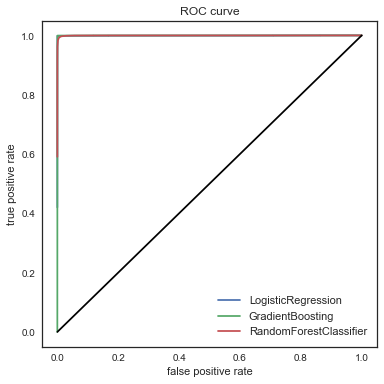

In [40]:
# this step takes a while to process.
# Be patient the models are being generated, predictions made and results evaluated. 

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test)

In [41]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.995379,0.999383,0.999884,0.992959,0.996409
1,GradientBoosting,0.999180,0.999927,0.999769,0.998961,0.999365
2,RandomForestClassifier,0.985064,0.999653,0.993354,0.983493,0.988399


## Final Notes: 
    - We could also do another split for cross validation and hyperparameter tunning, which could improve the performance of the models however this is time consuming and I considered it to be out of the scope of this challenge. Besides: the performances are outstanding already. 